# Atividade 2 - Etapa 2

[Proposta](https://docs.google.com/document/d/e/2PACX-1vTvlDZCbl8BtQfBQ3a0CPt_KDnxzQx_8E18iJMJxZ5R05cgX18hx0R8iwd5g3didFwDUHpJRRkqqQqs/pub)

Utilizar uma rede CNN pré-treinada:
- Escolher o modelo de rede
- Realizar transferência de aprendizado
- Verificar resultados e tempo de aprendizagem

## Base de Dados

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list
!kaggle datasets download 'smaranjitghose/corn-or-maize-leaf-disease-dataset'

Saving kaggle.json to kaggle.json
401 - Unauthorized - Unauthenticated
Dataset URL: https://www.kaggle.com/datasets/smaranjitghose/corn-or-maize-leaf-disease-dataset
License(s): copyright-authors
 98% 158M/161M [00:07<00:00, 25.1MB/s]
100% 161M/161M [00:07<00:00, 23.3MB/s]


In [ ]:
!unzip -qq corn-or-maize-leaf-disease-dataset.zip
!rm corn-or-maize-leaf-disease-dataset.zip

### Carregando Dataset em Tensor do pyTorch

In [ ]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, random_split

# Defina o diretório raiz onde estão suas pastas de treinamento e validação
root_dir = '/content/data'

# USE O CHATGPT PARA MONTAR ESSA PARTE - O TRUQUE DO NOTEBOOK ESTÁ AQUI

print('Classes:',dataset.classes)

Classes: ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']


In [ ]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Visualizando Dados

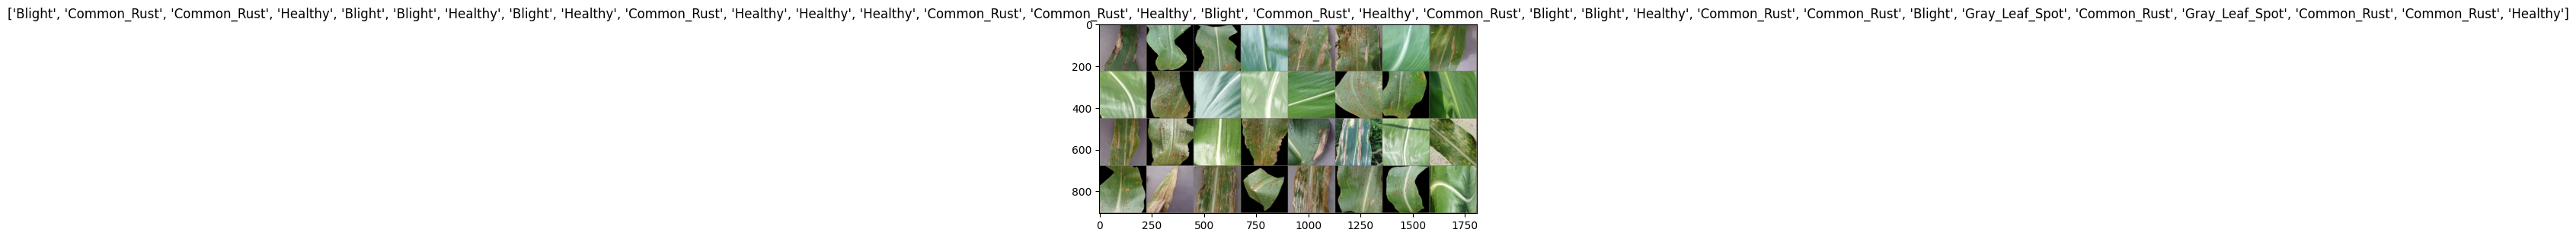

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# imshow para imagens em tensores
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[dataset.classes[x] for x in classes])

## ResNet versão 18

In [ ]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, len(dataset.classes))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 72.0MB/s]


### Transfer Learning

In [ ]:
import time
import copy

def treinamento(model, criterion, optimizer, scheduler, num_epochs=25):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print(f'Época {epoch}/{num_epochs - 1}')
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()  # Set model to training mode
      else:
        model.eval()   # Set model to evaluate mode

      running_loss = 0.0
      running_corrects = 0

      # Iterate over data.
      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # backward + optimize only if in training phase
            if phase == 'train':
                loss.backward()
                optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

      if phase == 'train':
          scheduler.step()

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      print(f'{phase} Perda: {epoch_loss:.4f} Acur: {epoch_acc:.4f}')

      # deep copy the model
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    print()

  time_elapsed = time.time() - since
  print(f'Treinamento completo em {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  print(f'Melhor acurácia: {best_acc:4f}')

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model

model_ft = treinamento(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Época 0/24
----------
train Perda: 0.4311 Acur: 0.8457
val Perda: 0.2141 Acur: 0.9272

Época 1/24
----------
train Perda: 0.1422 Acur: 0.9516
val Perda: 0.1638 Acur: 0.9332

Época 2/24
----------
train Perda: 0.0888 Acur: 0.9743
val Perda: 0.1426 Acur: 0.9487

Época 3/24
----------
train Perda: 0.0601 Acur: 0.9836
val Perda: 0.1578 Acur: 0.9487

Época 4/24
----------
train Perda: 0.0422 Acur: 0.9907
val Perda: 0.1405 Acur: 0.9487

Época 5/24
----------
train Perda: 0.0252 Acur: 0.9955
val Perda: 0.1456 Acur: 0.9475

Época 6/24
----------
train Perda: 0.0166 Acur: 0.9976
val Perda: 0.1456 Acur: 0.9463

Época 7/24
----------
train Perda: 0.0159 Acur: 0.9985
val Perda: 0.1479 Acur: 0.9475

Época 8/24
----------
train Perda: 0.0141 Acur: 0.9985
val Perda: 0.1503 Acur: 0.9463

Época 9/24
----------
train Perda: 0.0136 Acur: 0.9979
val Perda: 0.1484 Acur: 0.9511

Época 10/24
----------
train Perda: 0.0127 Acur: 0.9988
val Perda: 0.1531 Acur: 0.9475

Época 11/24
----------
train Perda: 0.0094

Olha que beleza!

Treinamento completo em 11m 33s

Melhor acurácia: 95.1 %

Lembra o modelo anterior treinado do zero? Menos de 27% de acurácia.

### Salvando o modelo treinado

In [ ]:
arquivo_modelo = 'folhasMilhoDP.pth'
torch.save(model_ft,arquivo_modelo)
from google.colab import files
files.download(arquivo_modelo)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Avaliando o Treinamento

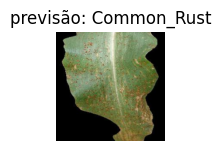

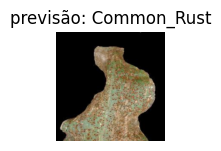

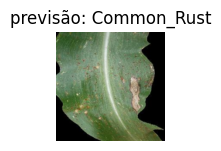

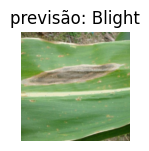

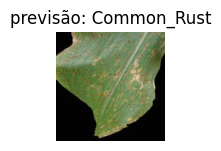

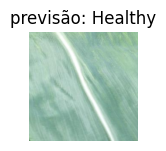

In [ ]:
def visualizando(model, num_images=6):
  was_training = model.training
  model.eval()
  images_so_far = 0
  fig = plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['val']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.size()[0]):
        images_so_far += 1
        ax = plt.subplot(num_images//2, 2, images_so_far)
        ax.axis('off')
        ax.set_title(f'previsão: {dataset.classes[preds[j]]}')
        imshow(inputs.cpu().data[j])

        if images_so_far == num_images:
            model.train(mode=was_training)
            return
  model.train(mode=was_training)

visualizando(model_ft)

### Caso precise caregar o arquivo de modelo salvo

In [ ]:
from google.colab import files
conteudo = files.upload()
arquivo_modelo = list(conteudo.keys())[0]
model_ft = torch.load(arquivo_modelo)
model_ft.eval()